In [1]:
# import needed libraries
import sys
from collections import OrderedDict
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
# path of local project
folder_path = "/home/jiaxiangyi/Documents/rvesimulator"
sys.path.insert(0, folder_path) 

# import local packages and functions 
import rvesimulator 
from simulator_caller import SimulatorCaller
from rvesimulator.design_of_experiment.samplers import FixNumberSampler
from rvesimulator.simulators.path_generator import PathGenerator

In [2]:
# create the doe
# define the design space
doe_variables = OrderedDict({"vol_req": 0.30, "control_points": 7})

# define number of samples
num_points = 2
# define the information of outputs
name_outputs = ["vol_frac", "PK2", "Green_strain", "ALLPD"]
doe_sampler = FixNumberSampler()
doe_sampler.sampling(
    num_samples=num_points,
    design_space=doe_variables,
    out_names=name_outputs,
    seed=123456,
)
data = doe_sampler.data
print(data)

{'samples':    vol_req  control_points
0      0.3             7.0
1      0.3             7.0, 'responses':   vol_frac  PK2 Green_strain ALLPD
0      NaN  NaN          NaN   NaN
1      NaN  NaN          NaN   NaN}


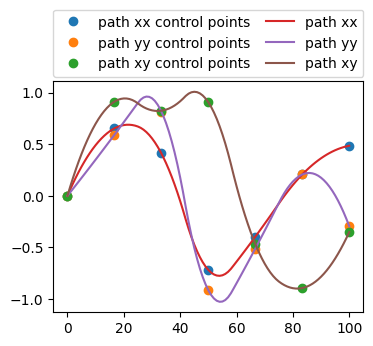

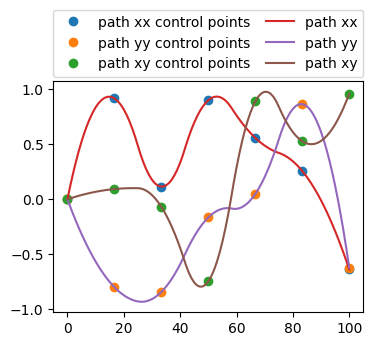

{'samples':    vol_req  control_points                                         loads_path  \
0      0.3             7.0  [[0.0, -0.08629433665371762, -0.16477846550464...   
1      0.3             7.0  [[0.0, 0.057740027592984224, 0.110632646402892...   

                                          loads_path  
0  [[0.0, 0.06242455629569218, 0.1218836367026862...  
1  [[0.0, 0.12199439973897111, 0.235442369655732,...  , 'responses':   vol_frac  PK2 Green_strain ALLPD
0      NaN  NaN          NaN   NaN
1      NaN  NaN          NaN   NaN}


In [6]:
#
loads_path_temp = np.empty([num_points, 1])
loads_path_temp[:] = np.nan
# print(loads_path_temp)
loads_path = pd.DataFrame(loads_path_temp, columns=["loads_path"])
loads_path["loads_path"] = loads_path["loads_path"].astype(object)
# print(loads_path)

# define the path generator
for ii in range(num_points):
    path_generator = PathGenerator(num_control_points=data["samples"].at[ii, "control_points"])   
    loads_path.iloc[ii, 0] = path_generator.quadratic_interpolate()
    path_generator.plot_path()

# add the loads path to the samples
data["samples"] = pd.concat(
    [data["samples"], loads_path], axis=1, join="inner"
)
print(data)

In [7]:
simulation_wrapper = SimulatorCaller()
simulation_wrapper.update_sim_info(
    loads=[0.02, 0.02, 0.02], mesh_partition=100, print_info=True
)

geometry information of RVE: {'length': 0.048, 'width': 0.048, 'radius': 0.003}
vol_req is: 0.3
Info of Abaqus simulation : {'mesh_partition': 100, 'loads': [0.02, 0.02, 0.02], 'time_period': 1.0, 'loads_path': None, 'E_matrix': 100.0, 'Pr_matrix': 0.3, 'yield_table_matrix': [[0.5, 0.5316978638492222, 0.541825582103651, 0.5491901897169873, 0.5551891864584486, 0.5603417633654516, 0.5649068444639842, 0.5690349813196016, 0.5728225681210433, 0.5763355781923636, 0.5796214341106994, 0.5827155324558011, 0.585645094733533, 0.5884315702256371, 0.5910922039712734, 0.5936410984009242, 0.5960899547185146, 0.5984486044506366, 0.6007253992982465, 0.6029275027715475, 0.6050611121761507, 0.6071316302061533, 0.6091437994192216, 0.6111018089314695, 0.6130093800197907, 0.6148698354997035, 0.616686156474797, 0.6184610291500892, 0.6201968837498333, 0.6218959271038169, 0.6235601701134824, 0.6251914510450486, 0.6267914553968891, 0.6283617329355872, 0.6299037123771667, 0.6314187140982368, 0.6329079611897948, 

In [ ]:
data = simulation_wrapper.run_simulation(data=data)


In [12]:
# read back the results from the pickle file 
import pickle
import os
print(os.getcwd())
with open("Data/data.pickle", "rb") as fd:
    data = pickle.load(fd, fix_imports=True, encoding="latin1")

/home/jiaxiangyi/Documents/rvesimulator/examples/pnas_composite


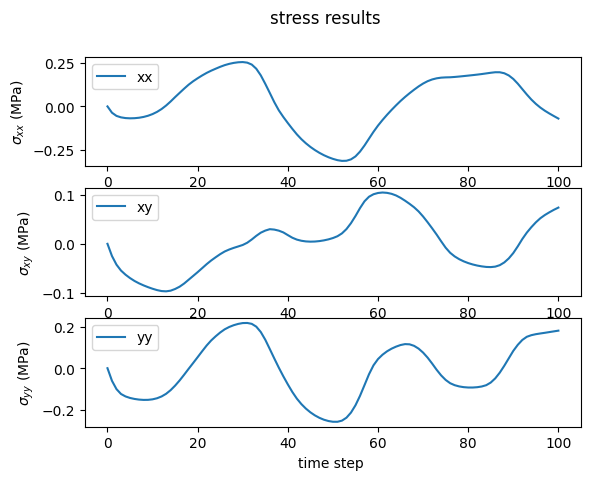

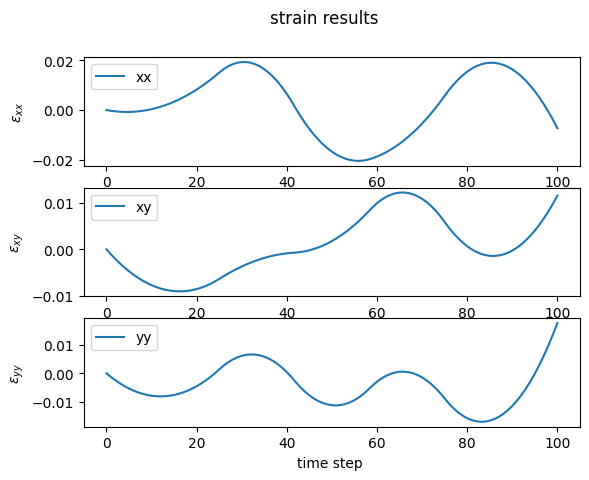

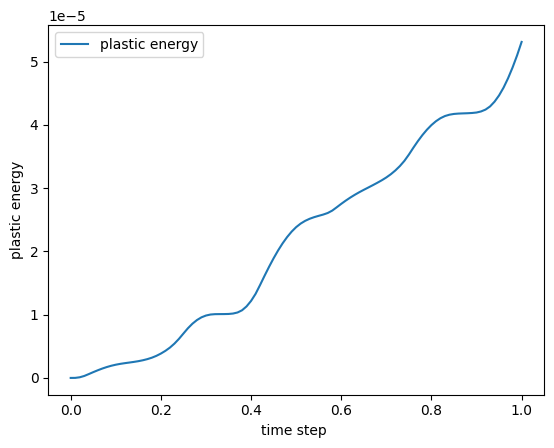

In [13]:
# simulation results for the first sample

results = data["responses"]


PK2 = results["PK2"].iloc[0]
Green_strain = results["Green_strain"].iloc[0]
ALLPD = results["ALLPD"].iloc[0]

pparam = dict(xlabel='time step ', ylabel="$\sigma_{xx}$ (MPa)")
fig, ax = plt.subplots(3,1)
# lt.figure()
# ax.plot(Green_strain[:,0,0],  PK2[:,0,0], label = 'PK2')
ax[0].plot(PK2[:, 0, 0], label="xx") 
ax[0].legend()
ax[0].set(**pparam)
pparam = dict(xlabel='time step ', ylabel="$\sigma_{xy}$ (MPa)")
ax[1].plot(PK2[:, 1, 0], label="xy")
ax[1].legend()
ax[1].set(**pparam)
pparam = dict(xlabel='time step ', ylabel="$\sigma_{yy}$ (MPa)")
ax[2].plot(PK2[:, 1, 1], label="yy") 
ax[2].legend()
ax[2].set(**pparam)
fig.suptitle('stress results')
# plt.show()
plt.savefig('stress.png', dpi=300)


pparam = dict(xlabel='time step ', ylabel="$\epsilon_{xx}$")
fig, ax = plt.subplots(3,1)
ax[0].plot(Green_strain[:, 0, 0], label="xx") 
ax[0].legend()
ax[0].set(**pparam)
pparam = dict(xlabel='time step ', ylabel="$\epsilon_{xy}$")
ax[1].plot(Green_strain[:, 0, 1], label="xy")
ax[1].legend()
ax[1].set(**pparam)
pparam = dict(xlabel='time step ', ylabel="$\epsilon_{yy}$")
ax[2].plot(Green_strain[:, 1, 1], label="yy") 
ax[2].legend()
ax[2].set(**pparam)
fig.suptitle('strain results')
plt.savefig('strain.png', dpi=300)

pparam = dict(xlabel='time step ', ylabel="plastic energy")
fig, ax = plt.subplots()
ax.plot(ALLPD[:,0], ALLPD[:,1], label="plastic energy") 
ax.legend()
ax.set(**pparam)
plt.savefig('energy.png', dpi=300)

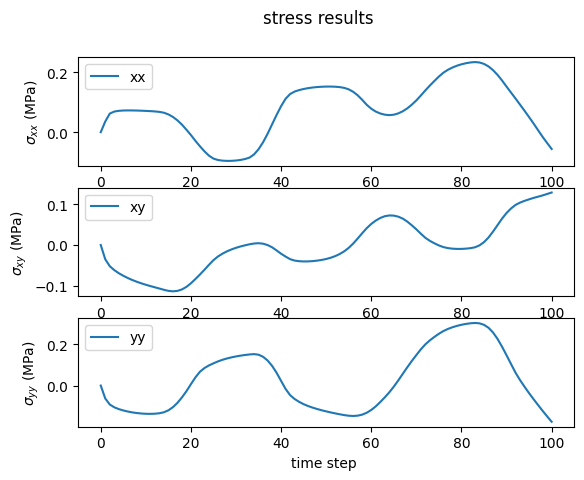

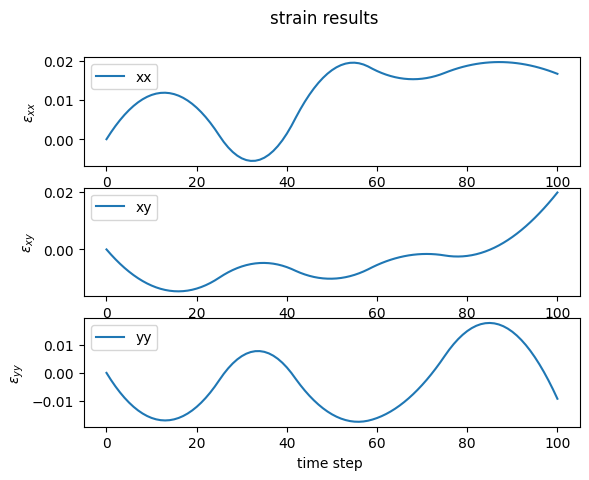

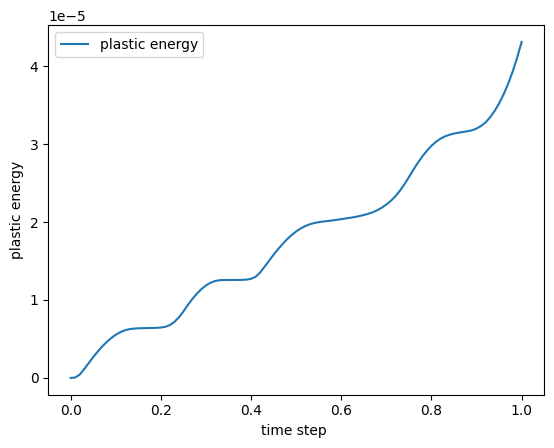

In [14]:

results = data["responses"]


PK2 = results["PK2"].iloc[1]
Green_strain = results["Green_strain"].iloc[1]
ALLPD = results["ALLPD"].iloc[1]

pparam = dict(xlabel='time step ', ylabel="$\sigma_{xx}$ (MPa)")
fig, ax = plt.subplots(3,1)
# lt.figure()
# ax.plot(Green_strain[:,0,0],  PK2[:,0,0], label = 'PK2')
ax[0].plot(PK2[:, 0, 0], label="xx") 
ax[0].legend()
ax[0].set(**pparam)
pparam = dict(xlabel='time step ', ylabel="$\sigma_{xy}$ (MPa)")
ax[1].plot(PK2[:, 1, 0], label="xy")
ax[1].legend()
ax[1].set(**pparam)
pparam = dict(xlabel='time step ', ylabel="$\sigma_{yy}$ (MPa)")
ax[2].plot(PK2[:, 1, 1], label="yy") 
ax[2].legend()
ax[2].set(**pparam)
fig.suptitle('stress results')
# plt.show()
plt.savefig('stress.png', dpi=300)


pparam = dict(xlabel='time step ', ylabel="$\epsilon_{xx}$")
fig, ax = plt.subplots(3,1)
ax[0].plot(Green_strain[:, 0, 0], label="xx") 
ax[0].legend()
ax[0].set(**pparam)
pparam = dict(xlabel='time step ', ylabel="$\epsilon_{xy}$")
ax[1].plot(Green_strain[:, 0, 1], label="xy")
ax[1].legend()
ax[1].set(**pparam)
pparam = dict(xlabel='time step ', ylabel="$\epsilon_{yy}$")
ax[2].plot(Green_strain[:, 1, 1], label="yy") 
ax[2].legend()
ax[2].set(**pparam)
fig.suptitle('strain results')
plt.savefig('strain.png', dpi=300)

pparam = dict(xlabel='time step ', ylabel="plastic energy")
fig, ax = plt.subplots()
ax.plot(ALLPD[:,0], ALLPD[:,1], label="plastic energy") 
ax.legend()
ax.set(**pparam)
plt.savefig('energy.png', dpi=300)